In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
import pandas as pd
from scipy.stats import spearmanr as spear
import statsmodels.api as sm

In [6]:
import seaborn as sns

In [13]:
def correlations(infile_e, infile_p, infile_a, infile_gt, outfile_res, dataset):
    llm_emeans, llm_pmeans, llm_ameans = [], [], []
    gt_emeans, gt_pmeans, gt_ameans = [], [], []
    concepts = []
    
    with open(infile_e, encoding='utf-8') as fe, open(infile_p, encoding='utf-8') as fp, open(infile_a, encoding='utf-8') as fa, open(infile_gt, encoding='utf-8') as f, open(outfile_res, 'w', encoding='utf-8') as fout:
        lines = f.readlines()[1:] 
        e_lines = fe.readlines()
        p_lines = fp.readlines()
        a_lines = fa.readlines()
        print(f"Number,Concept,Mean_GPT_E,Mean_GPT_P,Mean_GPT_A,Mean_{dataset}_E,Mean_{dataset}_P,Mean_{dataset}_A", file=fout)
        
        for l, el, pl, al in zip(lines, e_lines, p_lines, a_lines):
            seq_no, term_el = el.split(',', 1)
            term, el_values = term_el.split(',', 1)
            pl_values = pl.split(',', 2)[-1]
            al_values = al.split(',', 2)[-1]
            
            el_values = el_values.strip()
            pl_values = pl_values.strip()
            al_values = al_values.strip()
            
            el_values = eval(el_values)
            pl_values = eval(pl_values)
            al_values = eval(al_values)
            
            concepts.append(term)
            llm_emeans.append(np.mean(el_values))
            llm_pmeans.append(np.mean(pl_values))
            llm_ameans.append(np.mean(al_values))

            _, _, emean, pmean, amean = l.strip().split(',')
            gt_emeans.append(float(emean))
            gt_pmeans.append(float(pmean))
            gt_ameans.append(float(amean))

            print(f"{seq_no},{term},{llm_emeans[-1]},{llm_pmeans[-1]},{llm_ameans[-1]},{gt_emeans[-1]},{gt_pmeans[-1]},{gt_ameans[-1]}", file=fout)
            
    print("============= Spearman Matrix ================")
    print(spear(gt_emeans, gt_emeans))
    print(spear(gt_emeans, gt_pmeans))
    print(spear(gt_emeans, gt_ameans))
    print(spear(llm_emeans, gt_emeans))
    print(spear(llm_pmeans, gt_emeans))
    print(spear(llm_ameans, gt_emeans))
    print()
    print(spear(gt_pmeans, gt_emeans))
    print(spear(gt_pmeans, gt_pmeans))
    print(spear(gt_pmeans, gt_ameans))
    print(spear(llm_emeans, gt_pmeans))
    print(spear(llm_pmeans, gt_pmeans))
    print(spear(llm_ameans, gt_pmeans))
    print()
    print(spear(gt_ameans, gt_emeans))
    print(spear(gt_ameans, gt_pmeans))
    print(spear(gt_ameans, gt_ameans))
    print(spear(llm_emeans, gt_ameans))
    print(spear(llm_pmeans, gt_ameans))
    print(spear(llm_ameans, gt_ameans))
    print()
    print(spear(llm_emeans, gt_emeans))
    print(spear(llm_emeans, gt_pmeans))
    print(spear(llm_emeans, gt_ameans))
    print(spear(llm_emeans, llm_emeans))
    print(spear(llm_pmeans, llm_emeans))
    print(spear(llm_ameans, llm_emeans))
    print()
    print(spear(llm_pmeans, gt_emeans))
    print(spear(llm_pmeans, gt_pmeans))
    print(spear(llm_pmeans, gt_ameans))
    print(spear(llm_emeans, llm_pmeans))
    print(spear(llm_pmeans, llm_pmeans))
    print(spear(llm_ameans, llm_pmeans))
    print()
    print(spear(llm_ameans, gt_emeans))
    print(spear(llm_ameans, gt_pmeans))
    print(spear(llm_ameans, gt_ameans))
    print(spear(llm_emeans, llm_ameans))
    print(spear(llm_pmeans, llm_ameans))
    print(spear(llm_ameans, llm_ameans))

    data = {
        'GPT_E': llm_emeans,
        'GPT_P': llm_pmeans,
        'GPT_A': llm_ameans,
        f'{dataset}_E': gt_emeans,
        f'{dataset}_P': gt_pmeans,
        f'{dataset}_A': gt_ameans
    }
    df_corr = pd.DataFrame(data)
    corr_matrix = df_corr.corr(method='spearman')

    
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Spearman Correlation Heatmap')
    plt.show()



    print("================= Top 10 diffs ================")
    df = pd.DataFrame({'Concept': concepts,
                       'GPT_E_mean': llm_emeans,
                       'GPT_P_mean': llm_pmeans,
                       'GPT_A_mean': llm_ameans,
                       f'{dataset}_E_mean': gt_emeans,
                       f'{dataset}_P_mean': gt_pmeans,
                       f'{dataset}_A_mean': gt_ameans
                      })
    df['diff_E'] = df.apply(lambda x: abs(x[f'{dataset}_E_mean'] - x['GPT_E_mean']), axis=1)
    df['diff_P'] = df.apply(lambda x: abs(x[f'{dataset}_P_mean'] - x['GPT_P_mean']), axis=1)
    df['diff_A'] = df.apply(lambda x: abs(x[f'{dataset}_A_mean'] - x['GPT_A_mean']), axis=1)
    df['real_E'] = df.apply(lambda x: x[f'{dataset}_E_mean'] - x['GPT_E_mean'], axis=1)
    df['real_P'] = df.apply(lambda x: x[f'{dataset}_P_mean'] - x['GPT_P_mean'], axis=1)
    df['real_A'] = df.apply(lambda x: x[f'{dataset}_A_mean'] - x['GPT_A_mean'], axis=1)
    dfe = df.sort_values(by=['diff_E'], ascending=False).reset_index(drop=True).loc[:9]
    print("EVALUATION")
    print(dfe[['Concept', 'GPT_E_mean', f'{dataset}_E_mean', 'real_E']])
    dfp = df.sort_values(by=['diff_P'], ascending=False).reset_index(drop=True).loc[:9]
    print("POTENCY")
    print(dfp[['Concept', 'GPT_P_mean', f'{dataset}_P_mean', 'real_P']])
    dfa = df.sort_values(by=['diff_A'], ascending=False).reset_index(drop=True).loc[:9]
    print("ACTIVITY")
    print(dfa[['Concept', 'GPT_A_mean', f'{dataset}_A_mean', 'real_A']])

    with pd.ExcelWriter('results/top_diffs_m.xlsx') as writer:
        dfe = df.sort_values(by=['diff_E'], ascending=False).reset_index(drop=True).loc[:9]
        dfe[['Concept', 'GPT_E_mean', f'{dataset}_E_mean', 'real_E']].to_excel(writer, sheet_name='EVALUATION', index=False)
        
        dfp = df.sort_values(by=['diff_P'], ascending=False).reset_index(drop=True).loc[:9]
        dfp[['Concept', 'GPT_P_mean', f'{dataset}_P_mean', 'real_P']].to_excel(writer, sheet_name='POTENCY', index=False)
        
        dfa = df.sort_values(by=['diff_A'], ascending=False).reset_index(drop=True).loc[:9]
        dfa[['Concept', 'GPT_A_mean', f'{dataset}_A_mean', 'real_A']].to_excel(writer, sheet_name='ACTIVITY', index=False)


============= Spearman Matrix ================
SignificanceResult(statistic=1.0, pvalue=0.0)
SignificanceResult(statistic=0.4956383967217316, pvalue=1.796727533483103e-45)
SignificanceResult(statistic=-0.3677693126457588, pvalue=2.9532631275446e-24)
SignificanceResult(statistic=0.7756320452740025, pvalue=3.14305116640792e-144)
SignificanceResult(statistic=0.6985364593289626, pvalue=1.9526031525501003e-105)
SignificanceResult(statistic=-0.1503402106351388, pvalue=5.571099869669639e-05)

SignificanceResult(statistic=0.49563839672173166, pvalue=1.796727533483103e-45)
SignificanceResult(statistic=0.9999999999999999, pvalue=0.0)
SignificanceResult(statistic=-0.1563840409688102, pvalue=2.737378621043414e-05)
SignificanceResult(statistic=0.38340604879815, pvalue=2.19317241578655e-26)
SignificanceResult(statistic=0.6957123087730382, pvalue=2.985878777534853e-104)
SignificanceResult(statistic=0.26096082040254737, pvalue=1.4521342837128891e-12)

SignificanceResult(statistic=-0.3677693126457588, 

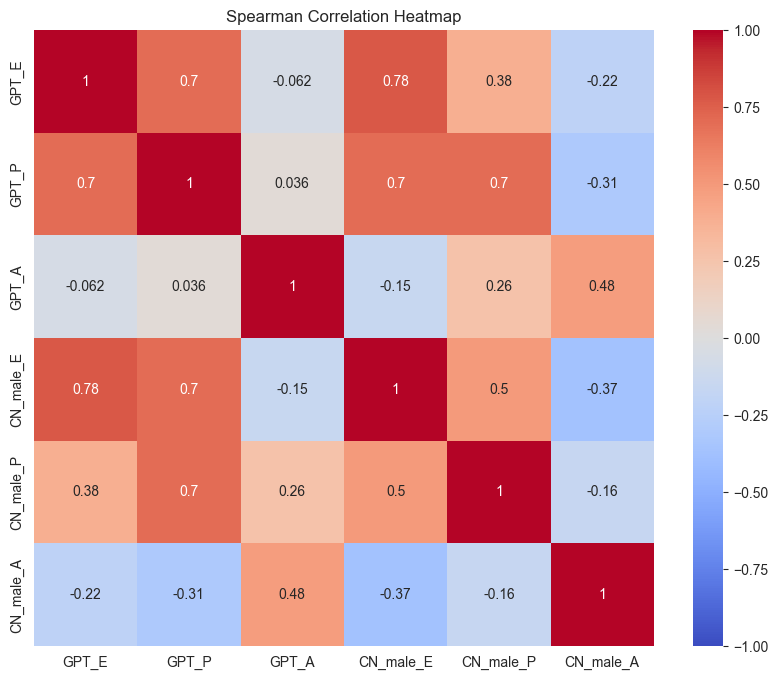

================= Top 10 diffs ================
EVALUATION
                    Concept  GPT_E_mean  CN_male_E_mean  real_E
0            lover (female)        2.90           -1.08   -3.98
1                     lover        2.90           -1.04   -3.94
2               that s.o.b.       -3.30            0.36    3.66
3              lover (male)        2.46           -1.13   -3.59
4                   realtor        0.54           -2.90   -3.44
5                    infant        3.00           -0.36   -3.36
6                   chinese        3.10           -0.19   -3.29
7             kindergartner        2.70           -0.32   -3.02
8   elementary school pupil        2.40           -0.51   -2.91
9                       son        3.14            0.28   -2.86
POTENCY
              Concept  GPT_P_mean  CN_male_P_mean  real_P
0           exploiter       -2.80            2.31    5.11
1               devil       -3.70            1.20    4.90
2               enemy       -3.10            1.70    4.

In [14]:
dataset = "CN_male"
infile_e = 'extracted/chatgpt_m_E_1_0_714.txt'
infile_p = 'extracted/chatgpt_m_P_1_0_714.txt'
infile_a = 'extracted/chatgpt_m_A_1_0_714.txt'
infile_gt = 'identities_cn_male.csv'
outfile_res = 'results/gpt4_CN_m_ide_ratings.csv'


correlations(infile_e, infile_p, infile_a, infile_gt, outfile_res, dataset)

In [4]:
ide_m_results = pd.read_csv('results/gpt4_CN_f_ide_ratings.csv')
ide_m_results.head()

,Number,Concept,Mean_GPT_E,Mean_GPT_P,Mean_GPT_A,Mean_CN_male_E,Mean_CN_male_P,Mean_CN_male_A
0,0,absent-minded person,-0.7,-1.84,-1.8,-0.90,-1.00,2.00
1,1,accomplice,-2.9,-1.96,2.1,-1.71,-0.89,0.41
2,2,accounting clerk,0.7,0.10,-1.1,1.00,0.30,-0.00
3,3,acquaintance (longtime),1.4,-0.02,-0.4,1.12,0.50,-0.00
4,4,actor,2.1,1.02,2.4,0.90,0.70,1.20


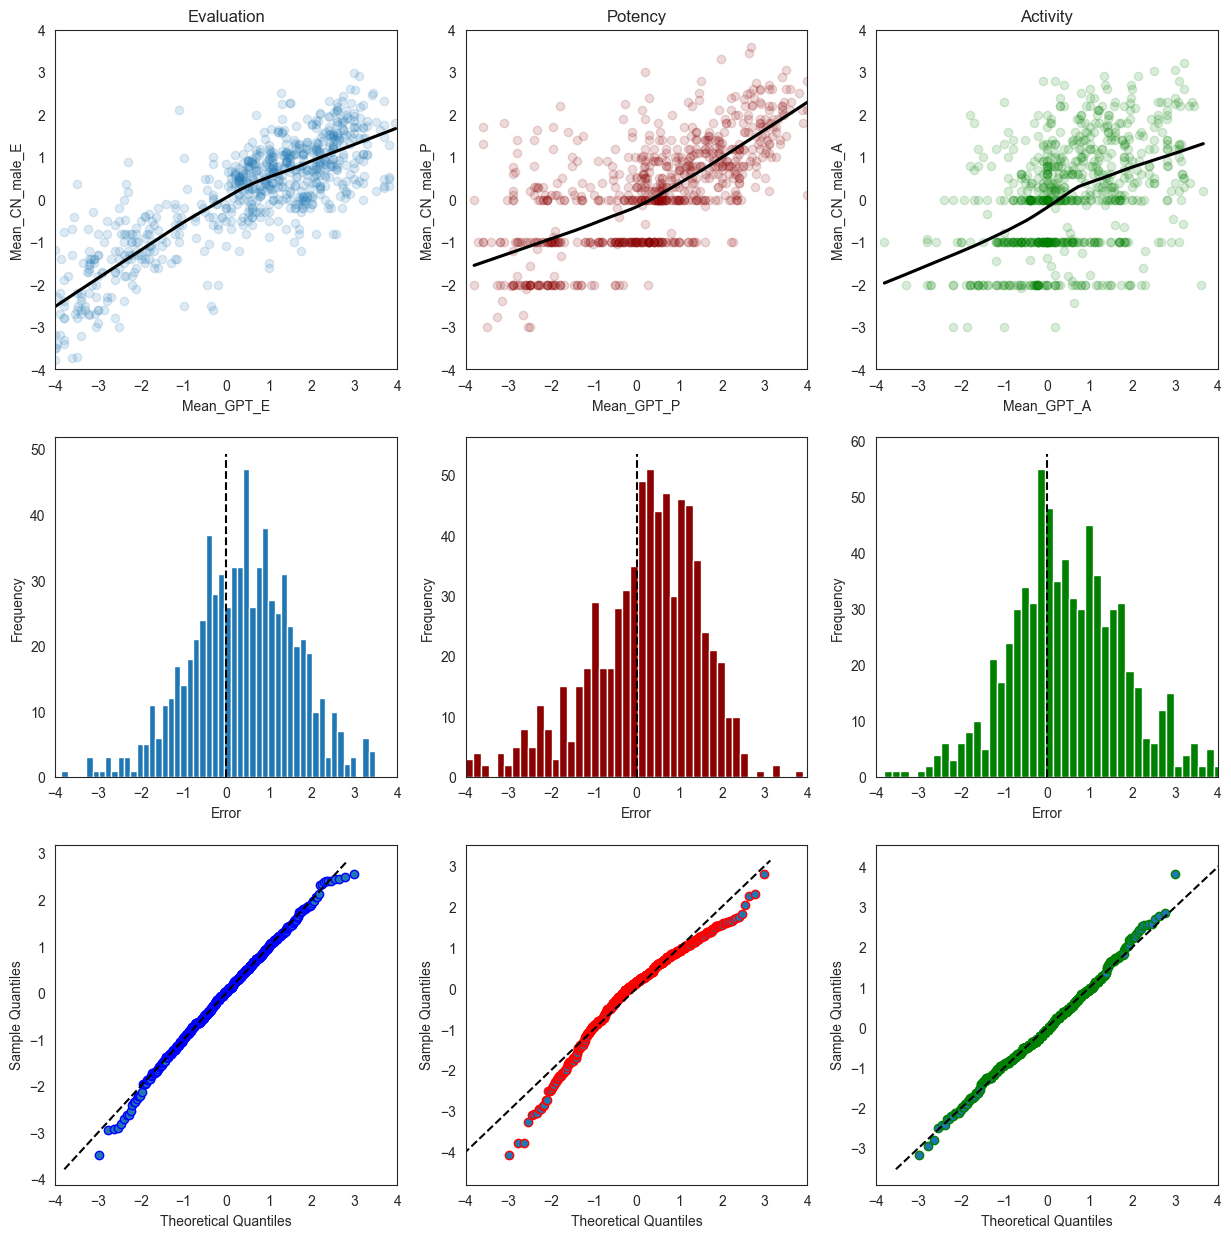

In [5]:
sb.set_style("white")

fig, axes = plt.subplots(3, 3, sharex=False, figsize=(15,15))

for i in range(3):
        axes[0][i].set_xlabel(f'Mean GPT-4 Rating CN')
        axes[0][i].set_ylabel(f"Mean CN Identity Dictionary Rating")
        axes[0][i].set_xlim([-4,4])
        axes[0][i].set_ylim([-4,4])

sb.regplot(data=ide_m_results, x='Mean_GPT_E', y='Mean_CN_male_E', lowess=True,ax=axes[0][0],
               line_kws={"color":"black"},
               scatter_kws={"alpha":0.15})
axes[0][0].set_title("Evaluation")

sb.regplot(data=ide_m_results, x='Mean_GPT_P', y='Mean_CN_male_P', lowess=True,ax=axes[0][1],
               line_kws={"color":"black"},
               scatter_kws={"alpha":0.15,"color":"darkred"})
axes[0][1].set_title("Potency")

sb.regplot(data=ide_m_results,x='Mean_GPT_A', y='Mean_CN_male_A', lowess=True,ax=axes[0][2],
               line_kws={"color":"black"},
               scatter_kws={"alpha":0.15, "color": "green"})
axes[0][2].set_title("Activity")


axes[1][0].hist(ide_m_results['Mean_GPT_E'] - ide_m_results['Mean_CN_male_E'], bins=50)
axes[1][1].hist(ide_m_results['Mean_GPT_P'] - ide_m_results['Mean_CN_male_P'], bins=50, color="darkred")
axes[1][2].hist(ide_m_results['Mean_GPT_A'] - ide_m_results['Mean_CN_male_A'], bins=50, color="green")
for i in range(3):
        axes[1][i].set_xlabel('Error')
        axes[1][i].set_ylabel("Frequency")
        axes[1][i].set_xlim([-4,4])
        line = np.array(axes[1][i].get_ylim())
        axes[1][i].plot(np.zeros(len(line)), line, linestyle="--", color="black")


sm.qqplot(ide_m_results['Mean_GPT_E'] - ide_m_results['Mean_CN_male_E'], fit=True, ax=axes[2][0], markeredgecolor='b')
sm.qqplot(ide_m_results['Mean_GPT_P'] - ide_m_results['Mean_CN_male_P'], fit=True, ax=axes[2][1], markeredgecolor='r')
sm.qqplot(ide_m_results['Mean_GPT_A'] - ide_m_results['Mean_CN_male_A'], fit=True, ax=axes[2][2], markeredgecolor='g')

for i in range(3):
        axes[2][i].set_xlabel('Theoretical Quantiles')
        axes[2][i].set_ylabel("Sample Quantiles")
        axes[2][i].set_xlim([-4,4])
        line = np.array(axes[2][i].get_ylim())
        axes[2][i].plot(line, line, linestyle="--", color="black")


In [ ]:
sb.set_style("white")

    fig, axes = plt.subplots(3, 3, sharex=False, figsize=(15,15))

    for i in range(3):
        axes[0][i].set_xlabel(f'Mean GPT-4 Rating ({dataset})')
        axes[0][i].set_ylabel(f"Mean {dataset_name} Rating")
        axes[0][i].set_xlim([-4,4])
        axes[0][i].set_ylim([-4,4])

    sb.regplot(x=llm_emeans, y=gt_emeans, lowess=True, ax=axes[0][0],
               line_kws={"color":"black"},
               scatter_kws={"alpha":0.15})
    axes[0][0].set_title("Evaluation")

    sb.regplot(x=llm_pmeans, y=gt_pmeans, lowess=True, ax=axes[0][1],
               line_kws={"color":"black"},
               scatter_kws={"alpha":0.15,"color":"darkred"})
    axes[0][1].set_title("Potency")

    sb.regplot(x=llm_ameans, y=gt_ameans, lowess=True, ax=axes[0][2],
               line_kws={"color":"black"},
               scatter_kws={"alpha":0.15, "color": "green"})
    axes[0][2].set_title("Activity")

    axes[1][0].hist(np.subtract(llm_emeans, gt_emeans), bins=50)
    axes[1][1].hist(np.subtract(llm_pmeans, gt_pmeans), bins=50, color="darkred")
    axes[1][2].hist(np.subtract(llm_ameans, gt_ameans), bins=50, color="green")
    for i in range(3):
        axes[1][i].set_xlabel('Error')
        axes[1][i].set_ylabel("Frequency")
        axes[1][i].set_xlim([-4,4])
        line = np.array(axes[1][i].get_ylim())
        axes[1][i].plot(np.zeros(len(line)), line, linestyle="--", color="black")

    sm.qqplot(x=np.subtract(llm_emeans, gt_emeans), fit=True, line='45', ax=axes[2][0])
    sm.qqplot(x=np.subtract(llm_pmeans, gt_pmeans), fit=True, line='45', ax=axes[2][1])
    sm.qqplot(x=np.subtract(llm_ameans, gt_ameans), fit=True, line='45', ax=axes[2][2])

    for i in range(3):
        axes[2][i].set_xlabel('Normal ppf')
        axes[2][i].set_ylabel("Error")
        axes[2][i].set_xlim([-4,4])
        line = np.array(axes[2][i].get_ylim())
        axes[2][i].plot(line, line, linestyle="--", color="black")

    plt.show()
    fig.savefig(outfile_fig)